In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn.parameter import Parameter
%matplotlib inline
import pylab as pl
from IPython import display
import time

In [2]:
class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, inp):
        return self.layers(inp)

class ENCODER(nn.Module):
    def __init__(self):
        super(ENCODER, self).__init__()
        self.block1 = Block(3,64)
        self.block2 = Block(64,64)
        self.block3 = Block(64,64)
        self.block4 = Block(64,64)
#         self.final = nn.Conv2d(64,64, kernel_size=1, padding=0)
        
    def forward(self, inp):
        out = self.block1(inp)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
#         out = self.final(out)
        return out.view(out.size(0),-1)
    
class PREDICTOR(nn.Module):
    def __init__(self):
        super(PREDICTOR, self).__init__()
        self.sm = nn.LogSoftmax()
        
    def forward(self, support, inp, way):
        assert support.size(0)%way == 0,"Error: classes are not the same size!"
        support = support.view(way,support.size(0)//way,-1)
        centroids = torch.mean(support, 1).view(support.size(0),-1)
#         temp1 = torch.stack([centroids]*inp.size(0))
#         temp2 = torch.stack([inp]*centroids.size(0)).transpose(0,1)
#         print(temp1.size(),temp2.size())
        distmat = torch.sum((torch.stack([centroids]*inp.size(0))-torch.stack([inp]*centroids.size(0))
                             .transpose(0,1))**2,2).squeeze()*-1
        probs = self.sm(distmat)
        return probs

In [3]:
trainset = torch.load('mIN_train.pth')
testset = torch.load('mIN_test.pth')
valset = torch.load('mIN_val.pth')

In [7]:
standardize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.485,.456,.406],std=[.229,.224,.225])
            ])
alter = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(84,padding=10),
            standardize
            ])

def batchmaker(way,trainshot,testshot,theset,alterful=False):
    classes = np.random.choice(len(theset),way)
    if alterful:
        li = [torch.cat([alter(theset[cl][i]).view(1,3,84,84) for i in 
                         np.random.choice(600,trainshot+testshot)],dim=0).float()
              for cl in classes]
    else:
        li = [torch.cat([standardize(theset[cl][i]).view(1,3,84,84) for i in 
                         np.random.choice(600,trainshot+testshot)],dim=0).float()
              for cl in classes]
    support = torch.cat([t[:trainshot,:,:,:] for t in li],dim=0)
    stargs = torch.LongTensor([i//trainshot for i in range(trainshot*way)])
    query = torch.cat([t[trainshot:,:,:,:] for t in li],dim=0)
    qtargs = torch.LongTensor([i//testshot for i in range(testshot*way)])
#     print(support.size(),query.size())
    return(Variable(support).cuda(),
           Variable(query, volatile=(not alterful)).cuda(),
           Variable(qtargs, volatile=(not alterful)).cuda(),
           Variable(stargs).cuda()
          )

def evaluate(embed,model,criterion,way,trainshot,testshot,reps,theset):
    losstracker = 0
    acctracker = 0
    acclist = []
    for i in range(reps):
        s,q,qt,st = batchmaker(way,trainshot,testshot,theset)
        embeds = embed(s)
        qembeds = embed(q)
        preds = model(embeds,qembeds,way)
        
        # Val loss
        loss = criterion(preds,qt)
        losstracker += loss.data[0]
        
        # Val accuracy
        _,bins = torch.max(preds,1)
        acc = torch.sum(torch.eq(bins,qt)).data[0]/testshot/way
        acctracker += acc
        acclist.append(acc)
    return losstracker/reps,acctracker/reps,np.var(acclist)

way = 20
evalway = 5
trainshot = 30
testshot = 5
reps = 100

In [5]:
torch.cuda.set_device(0)

In [8]:
embed = ENCODER().cuda()
model = PREDICTOR().cuda()
losstracker,l2losstracker,evallosstracker,evalacctracker = [],[],[],[]
optimizer = None
nweights = sum([i.numel() for i in list(embed.parameters())])
print(nweights," parameters in neural net.")

113088  parameters in neural net.


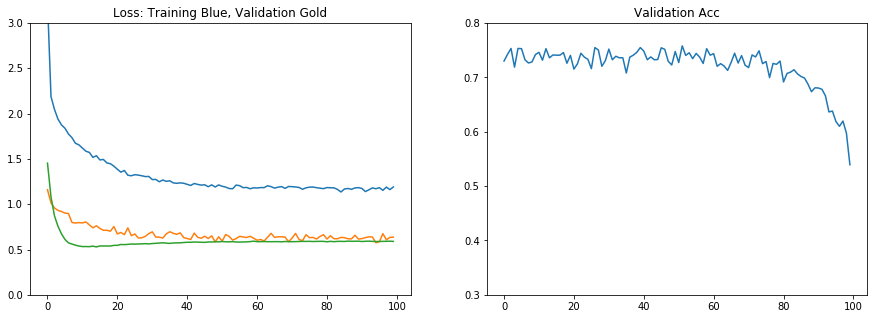

Train loss is: 1.190390727519989
L2 norm is: 5.894390897750855
Validation accuracy is: 0.7300000000000003
Validation loss is: 0.636213553249836

5860.016466856003


In [9]:
# TRAIN!
criterion = nn.NLLLoss().cuda()
vbity = 200
epoch = 2000
start = time.time()

runningloss, runningl2loss = 0, 0
for it in range(10*epoch):
    if it%10==0:
        print(it)
    
    # Build batch
    support, query, targs, _ = batchmaker(way,trainshot,testshot,trainset,alterful=True)
    
    # Predict
    embed.zero_grad()
    model.zero_grad()
    embeds = embed(support)
    qembeds = embed(query)
    preds = model(embeds,qembeds,way)

    # Calculate Loss
    loss = criterion(preds, targs)
    l2loss = torch.mean(torch.norm(qembeds, dim=1))
    totalloss = loss+l2loss/100
    runningloss += loss.data[0]
    runningl2loss += l2loss.data[0]
    
    # Backprop
    if it%epoch == 0:
        optimizer = optim.Adam(embed.parameters(),lr=.001/(2**(it//epoch)))
    totalloss.backward()
#     nn.utils.clip_grad_norm(model.parameters(), 1)
    optimizer.step()
    
    # Report
    if it%vbity == vbity-1:
        display.clear_output(wait=True)

        losstracker.append(runningloss/vbity)
        l2losstracker.append(runningl2loss/vbity/10)
        embed = embed.eval()
        evalloss, evalacc, _ = evaluate(embed,model,criterion,evalway,trainshot,testshot,reps,testset)
        embed = embed.train()
        evallosstracker.append(evalloss)
        evalacctracker.append(evalacc)
        
        pl.figure(1,figsize=(15,5))
        pl.subplot(1,2,1)
        pl.plot(losstracker)
        pl.plot(evallosstracker)
        pl.plot(l2losstracker)
        pl.ylim((0,3))
        pl.title("Loss: Training Blue, Validation Gold")
        pl.subplot(1,2,2)
        pl.plot(evalacctracker[::-1])
        pl.ylim((0.3,.8))
        pl.title("Validation Acc")
        pl.show()
        
        print("Train loss is: "+str(runningloss/vbity)+
              "\nL2 norm is: "+str(runningl2loss/vbity)+
              "\nValidation accuracy is: "+str(evalacc)+
              "\nValidation loss is: "+str(evalloss)+"\n")
        runningloss = 0
        runningl2loss = 0
        print(time.time()-start)

# MORE RECENT TEST
        

In [12]:
criterion = nn.NLLLoss().cuda()
embed = embed.cuda()
embed = embed.eval()
print(evaluate(embed,model,criterion,evalway,5,testshot*3,200,testset))
embed = embed.train()

(1.0421067474782466, 0.6425333333333333, 0.010061137777777777)


In [10]:
1.96*np.sqrt(.0090525/200)

0.01318637251104336

In [25]:
np.mean(evalacctracker[-50:])

0.65521600000000002

In [10]:
name = 'L2_highshot'
torch.save((embed,model,losstracker,evallosstracker,evalacctracker),'saved_models/'+name+'.pth')
torch.save(embed.cpu().state_dict(),'saved_models/'+name+'_cpu.pth')

/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ENCODER. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type PREDICTOR. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
embed,model,losstracker,evallosstracker,evalacctracker = torch.load('saved_models/naive_4.pth')

In [ ]:
Paper model achieves (over last 1000):
    0.71156711111111126
after 188500 iters

In [213]:
support = supportmaker(nclass,shot)
inp = inpmaker(nclass)
embeds = embed(support)
query = embed(inp)
model(embeds,query)

Variable containing:
-6.7075e-03 -5.0079e+00 -2.7911e+01
-2.9057e+00 -5.6263e-02 -4.5704e+01
-1.8272e+01 -4.3870e+01 -1.1600e-08
[torch.FloatTensor of size 3x3]